#Assignment Advance Data Science
###Topic Name -  Granger Causality and Causal Inference
Name -  Viral Jangale

Nuid - 002654463

This command will install the `fredapi` package from the Python Package Index (PyPI) into your Python environment, allowing you to use the functionalities provided by this package to interact with the Federal Reserve Economic Data (FRED) API.

In [ ]:
# !pip install fredapi

In [ ]:
import numpy as np
import pandas as pd
import os

from sklearn.metrics import mean_squared_error as mse

import matplotlib.pyplot as plt
import matplotlib.dates as md
%matplotlib inline

# from fredapi import Fred
# fred = Fred(api_key='fred')

from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.api import VAR
from statsmodels.tsa.ar_model import AutoReg

plt.style.use('fivethirtyeight')

In [ ]:
def my_rmse(x,y):
    return(np.round( np.sqrt(mse(x,y)) ,4))

In [ ]:
# general settings
class CFG:
    img_dim1 = 20
    img_dim2 = 10
    tail = 30
    varlag = 4

# adjust the parameters for displayed figures
plt.rcParams.update({'figure.figsize': (CFG.img_dim1,CFG.img_dim2)})


<a id="section-granger"></a>
# Granger causality

Granger causality is a statistical concept used to determine whether one time series can predict another. Named after economist Clive Granger, this concept is particularly useful in analyzing cause-and-effect relationships in time-series data without necessarily implying direct causation in the traditional sense.

Here's a breakdown of Granger causality:

### Time Series Data:
- **Time Series:** A sequence of data points recorded in chronological order.

### Granger Causality Principle:
- **Basic Idea:** If a variable (let's say Variable A) helps predict another variable (Variable B) better than just the past values of Variable B alone, then Variable A is said to have Granger-causal influence on Variable B.
- **Time Lag:** Granger causality examines whether past values of one variable help predict future values of another variable.
- **Statistical Test:** It involves running statistical tests (often F-tests) to compare predictive models that include and exclude past values of the potential causal variable.
  
<img src="https://warwick.ac.uk/fac/sci/dcs/research/combi/research/compneuro/granger.png?maxWidth=600&maxHeight=373">

### Application:
- **Economics and Finance:** Commonly used in economics and finance to explore relationships between economic indicators, like GDP, interest rates, and consumer spending.
- **Science and Engineering:** Applied in various fields like neuroscience to understand brain activity, in meteorology for weather prediction, and in engineering for system analysis.

### Considerations:
- **Not True Causality:** Granger causality doesn't prove direct causation; it identifies predictive relationships between variables.
- **External Factors:** It doesn't account for all possible factors or external influences that might affect both variables being studied.

### Interpretation:
- **Positive Result:** If Granger causality is found, it suggests that one time series provides valuable information for predicting the future of another series.
- **Negative Result:** A lack of Granger causality doesn't necessarily mean there's no relationship between the variables; it just means the tested variable might not significantly improve predictions of the other variable.

### Key Steps:
1. **Data Preparation:** Organize the time series data for analysis.
2. **Model Specification:** Select appropriate lags and variables for the Granger causality test.
3. **Statistical Testing:** Use appropriate statistical tests to determine the presence of Granger causality.
4. **Interpretation:** Analyze the results and draw conclusions about the predictive relationship between the variables.

Granger causality is a valuable tool for understanding predictive relationships between time series data and identifying potential lead-lag associations but should be used cautiously and in conjunction with domain knowledge to draw meaningful conclusions about causation.
* Establishing causality in observational data is notoriously difficult

* Granger causality is a lower bar

* Original idea: comparing the predictive power for a process $Y$ using all the available information $U$ with the same using $U\backslash X$

* discarding X reduces the predictive power regarding Y $\implies$ X contains some unique information regarding Y $\rightarrow$ **X Granger-causes Y**

* in practice: if past (lagged) values of $X$ improve prediction of $Y$, conditional on its own past values, then $X$ Granger-causes $Y$

* Granger’s causality test: $H_0$ = coefficients of past values in the regression equation is zero $\rightarrow$ null is no causality


We will demonstrate Granger causality usefulness by predicting the price of evolution of major precious metals:
<img src="https://www.wallstreetmojo.com/wp-content/uploads/2023/10/Granger-Causality.png">

In [ ]:
df = pd.read_csv('https://github.com/Viral-28/ADS/raw/main/commodity_prices.csv',
                  usecols = ['date','GOLD', 'PLATINUM', 'SILVER'])
# process timestamp
df['date'] = pd.to_datetime(df['date'].apply(lambda s: s.replace('M', '-')))

df = df.set_index('date').rename_axis('metal', axis=1)

df.head()

metal,GOLD,PLATINUM,SILVER
date,,,
1960-01-01,35.27,83.5,0.91
1960-02-01,35.27,83.5,0.91
1960-03-01,35.27,83.5,0.91
1960-04-01,35.27,83.5,0.91
1960-05-01,35.27,83.5,0.91


In [ ]:
import plotly.express as px

fig = px.line(df, facet_col="metal", facet_col_wrap=1)
fig.update_yaxes(matches=None)
fig.show()

In [ ]:
# pd.plotting.lag_plot(df)

The visual representation above strongly indicates that the series lack stationarity, a necessary condition for constructing a VAR model. To confirm this notion, we'll put it to the test using the Augmented Dickey-Fuller method, a commonly employed approach.

Null hypothesis ($H_0$): The time series does not exhibit stationarity and instead maintains stationarity around a trend.

Alternative hypothesis ($H_1$): The time series demonstrates stationarity.

In [ ]:
def adf_test(df):
    result = adfuller(df.values)
    print('ADF Statistics: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

for f in df.columns:
    print('ADF Test: ' + str(f))
    adf_test(df[f])
    print('---')

ADF Test: GOLD
ADF Statistics: 0.302078
p-value: 0.977440
Critical values:
	1%: -3.439
	5%: -2.865
	10%: -2.569
---
ADF Test: PLATINUM
ADF Statistics: -1.386696
p-value: 0.588637
Critical values:
	1%: -3.439
	5%: -2.865
	10%: -2.569
---
ADF Test: SILVER
ADF Statistics: -2.066067
p-value: 0.258376
Critical values:
	1%: -3.439
	5%: -2.865
	10%: -2.569
---


All p-values above any reasonable critical level $\implies$ series are not stationary

An alternative method, the KPSS test, assesses whether the series displays stationarity around a mean or linear trend or if it's non-stationary due to a unit root.

Null hypothesis ($H_0$): The time series exhibits stationarity.

Alternative hypothesis ($H_1$): The time series lacks stationarity.

In [ ]:
from statsmodels.tsa.stattools import kpss

def kpss_test(df):
    statistic, p_value, n_lags, critical_values = kpss(df.values)

    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')

for f in ['GOLD', 'PLATINUM', 'SILVER']:
    print('KPSS Test: ' + str(f))
    kpss_test(df[f])
    print('---')

KPSS Test: GOLD
KPSS Statistic: 3.1595927383305833
p-value: 0.01
num lags: 17
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
---
KPSS Test: PLATINUM
KPSS Statistic: 3.199494610358769
p-value: 0.01
num lags: 17
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
---
KPSS Test: SILVER
KPSS Statistic: 2.405075459702326
p-value: 0.01
num lags: 17
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
---


<ipython-input-9-8f960d2ecec4>:4: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.


<ipython-input-9-8f960d2ecec4>:4: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.


<ipython-input-9-8f960d2ecec4>:4: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




The KPSS test examines whether a set of numbers, like the prices of gold, platinum, or silver, behaves consistently over time. Its goal is to determine if these numbers tend to stay around an average value (stationary) or if they frequently wander away from it (non-stationary). The test presents two possibilities: the null hypothesis suggests stability around an average, while the alternative suggests instability. By analyzing the data and generating a 'KPSS Statistic' and a 'p-value', it helps us grasp whether these prices remain predictable around an average value or if they often fluctuate, impacting their predictability. In simpler terms, it's like a detective checking if the prices of precious metals tend to consistently hover around a typical value or if they frequently stray, making future predictions more challenging.

Transform and try again:

In [ ]:
df_transformed = df.copy()

for f in df.columns:
    df_transformed[f] = df[f].pct_change().fillna(0)

fig = px.line(df_transformed, facet_col="metal", facet_col_wrap=1)
fig.update_yaxes(matches=None)
fig.show()

This code snippet takes a DataFrame 'df' containing columns representing different metals' prices (like gold, platinum, etc.). It creates a transformed DataFrame 'df_transformed' by calculating the percentage change for each metal's price using the `.pct_change()` function. This change computation helps understand how much each metal's price has shifted compared to its previous value. Any missing values resulting from this calculation are filled with zero to maintain continuity. The code then uses the Plotly Express library to generate a line plot with multiple facets (subplots) based on different metals in the DataFrame. Each subplot illustrates the price changes over time for a specific metal, offering a visual comparison of their price movements. Adjustments to the y-axes are made to ensure proper visualization without enforced matching between the different metals' price scales. Ultimately, this plot provides a clear, comparative view of how the prices of various metals fluctuate over time.

In [ ]:
for f in df_transformed.columns:
    print('ADF Test: ' + str(f))
    adf_test(df_transformed[f])
    print('---')

ADF Test: GOLD
ADF Statistics: -5.750824
p-value: 0.000001
Critical values:
	1%: -3.439
	5%: -2.865
	10%: -2.569
---
ADF Test: PLATINUM
ADF Statistics: -9.705005
p-value: 0.000000
Critical values:
	1%: -3.439
	5%: -2.865
	10%: -2.569
---
ADF Test: SILVER
ADF Statistics: -14.634814
p-value: 0.000000
Critical values:
	1%: -3.439
	5%: -2.865
	10%: -2.569
---


In [ ]:

for f in df_transformed.columns:
    print('KPSS Test: ' + str(f))
    kpss_test(df_transformed[f])
    print('---')

KPSS Test: GOLD
KPSS Statistic: 0.13475028705159106
p-value: 0.1
num lags: 7
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
---
KPSS Test: PLATINUM
KPSS Statistic: 0.08245174215299955
p-value: 0.1
num lags: 7
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
---
KPSS Test: SILVER
KPSS Statistic: 0.07523095832635517
p-value: 0.1
num lags: 6
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
---


<ipython-input-9-8f960d2ecec4>:4: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


<ipython-input-9-8f960d2ecec4>:4: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


<ipython-input-9-8f960d2ecec4>:4: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




A straightforward method to model a time series involves assuming a linear relationship between current and past values, often expressed as \(X_t = \theta X_{t-1} + \epsilon_t\),
where \(X_t\) and \(\theta\) are singular (univariate) entities.

VAR (Vector Autoregression) models expand on this concept by transitioning to a multivariate approach, substituting scalars with vectors and matrices, respectively. Although the underlying mathematics delve into linear algebra, the fundamental idea remains the same:

for a series \(X_t\) with \(k\) dimensions, the model is articulated as \(X_t = \sum_{i=1}^k A_i X_{t-k} + \epsilon_t\), wherein \(A_i\) represents \(k \times k\) matrices and \(\epsilon_t \sim N(0, \Sigma)\).

In essence, VAR models extend the autoregressive (AR) model to encompass multiple variables, leveraging prior knowledge about various variables that could plausibly influence each other over time.
Each variable within the model possesses its own equation, incorporating both lagged values of the target variable and lagged values of other variables. For instance, in a bivariate scenario, this translates to equations such as
\(X_{1,t} = A_{1,1} X_{1,t-1} + A_{1,2} X_{2,t-1} + \epsilon_{1,t}\) and \(X_{2,t} = A_{2,1} X_{1,t-1} + A_{2,2} X_{2,t-1} + \epsilon_{2,t}\).

* bi-directional influence

* baseline (VAR in level): all the series are **stationary**

With the theoretical setup out of the way, let's take VAR for a test drive.

In [ ]:
# blows up plotly, but needed to make VAR work in statsmodels ¯\_(ツ)_/¯
df_transformed.index = pd.DatetimeIndex(df_transformed.index).to_period('M')

Prepare a train/test split:

In [ ]:
df_train, df_test = df_transformed[0:- CFG.tail], df_transformed[-CFG.tail:]

In [ ]:
# start with univariate models

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

for (ff, xcol) in enumerate(df_train.columns):

    model = AutoReg(df_train[xcol], lags = CFG.varlag).fit()
    pred = model.forecast(df_test.shape[0])
    xerr = my_rmse(df_test[xcol].values, pred)
    df_test[xcol + ' - single'] = pred.values
    print(xcol + ' RMSE: ' + str(xerr))

GOLD RMSE: 0.0317
PLATINUM RMSE: 0.0673
SILVER RMSE: 0.0871


There are indications that previous trends in GOLD's performance could potentially forecast future changes in silver prices—or conversely. This notion prompts the need for a formal examination using Granger causality tests.


In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests

maxlag = CFG.varlag
test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):

    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df_train, variables = df_train.columns)

,GOLD_x,PLATINUM_x,SILVER_x
GOLD_y,1.0000,0.1217,0.1356
PLATINUM_y,0.0031,1.0000,0.0082
SILVER_y,0.2894,0.3953,1.0000


This function 'grangers_causation_matrix' uses Granger causality tests from the statsmodels library to compute the causality matrix for a given DataFrame 'df_train'. It assesses potential causal relationships between different variables (columns) within the DataFrame by iteratively applying the Granger causality test between pairs of variables. For each variable pair, it performs the test with a maximum lag specified by 'maxlag' and records the minimum p-value obtained across various lag lengths. The resulting matrix summarizes these minimum p-values, indicating the strength of potential causality between variables: lower p-values suggest stronger evidence of causality. The function returns a matrix where each row variable ('_y') potentially causes changes in each column variable ('_x'), aiding in identifying influential relationships between the variables in the dataset.

So we now have decent reason to formulate a VAR model

In [ ]:
# fit a joint multivariate model
lag_order =  CFG.varlag
model1 = VAR(df_train)
results = model1.fit(maxlags= lag_order , ic='aic')
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 12, Dec, 2023
Time:                     07:04:11
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -18.3942
Nobs:                     718.000    HQIC:                  -18.5468
Log likelihood:           3675.37    FPE:                8.00824e-09
AIC:                     -18.6428    Det(Omega_mle):     7.58854e-09
--------------------------------------------------------------------
Results for equation GOLD
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.004627         0.001699            2.724           0.006
L1.GOLD             0.305191         0.055315            5.517           0.000
L1.PLATINUM        -0.055871         0.043288           -1.291       

In [ ]:
# predict from the joint model
joint_forecast = results.forecast(df_train.values[-4:], df_test.shape[0])

pd.options.mode.chained_assignment = None

for (ff,xcol) in enumerate(df_train.columns):
    df_test[xcol + ' - joint'] = joint_forecast[:,ff]


In [ ]:
# evaluate
for xc in df_train.columns:
    print(xc + ': ')
    xerr = my_rmse(df_test[xc], df_test[xc + ' - single'])
    print('single: ' + str(xerr))
    xerr = my_rmse(df_test[xc].values, df_test[xc + ' - joint'])
    print('joint: ' + str(xerr))
    print('---')

GOLD: 
single: 0.0317
joint: 0.0315
---
PLATINUM: 
single: 0.0673
joint: 0.0671
---
SILVER: 
single: 0.0871
joint: 0.0867
---


As evident from the metrics presented earlier, integrating just a single lag from the other variables demonstrates an enhancement in forecast accuracy. Granger causality serves as a tool to help determine the relevance and viability of incorporating these additional lags for improved forecasting performance.



**Cautionary Note:** Asserting causation without due care can create perplexity.
   - Granger himself was hesitant about the term, noting, "It is questionable whether philosophers would fully endorse this definition, and the term 'cause' might be too forceful or emotionally charged to apply here."
   - Granger causality occurs when one time series informs future values of another, showcasing temporal correlation through time-shifted values.
   - It indicates co-movement or acts as a leading indicator.
   - Notably, Granger-causality can suggest bidirectional influence, indicating a feedback mechanism between the two series.
   - Despite this, it remains valuable for predictive purposes.

<a id="section-dowhy"></a>
# Causal Inference
Certainly! Causal inference dives into the heart of cause-and-effect relationships within data or systems. When we observe a correlation between two variables, like an increase in one coinciding with changes in another, causal inference seeks to understand if one truly causes the changes in the other or if there's merely an association.

To achieve this, it goes beyond simple observation. It involves techniques and methodologies to approximate causation from observational data, as controlled experiments are often impractical or unethical. This field employs various statistical models, such as regression analysis, propensity scores, or instrumental variables, to tease out causal relationships.

Consider an example where a medication is associated with a health improvement. Causal inference aims to discern if the medication indeed causes the better health or if other factors, like patient lifestyle or genetic makeup, might be responsible for the observed improvement.

It's a challenging area as establishing true causation from observed data requires careful consideration of potential biases, confounding variables, and temporal sequences. Despite these challenges, it's a fundamental field driving insights into understanding the true nature of relationships between different factors, critical in fields like medicine, social sciences, economics, and more.



What steps make up this interface?

1. Constructing a causal mechanism model: Building a causal graph grounded in domain knowledge $\rightarrow$ relying on established information.

2. Determining the target estimand: Formulating an accurate estimand derived from the causal model $\rightarrow$ specifying what needs estimation.

3. Estimating the causal effect: Employing an appropriate method to gauge the effect $\rightarrow$ understanding the method of estimation.

4. Validating estimations: Verifying the estimate's resilience against assumption violations $\rightarrow$ ensuring robustness, akin to how caution can lead to longevity.

<img src="https://blog.ml.cmu.edu/wp-content/uploads/2019/11/structure_diagram-493x1024.jpg">

In [ ]:
!pip install dowhy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.7/377.7 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.4/174.4 kB 22.0 MB/s eta 0:00:00


<img src="https://getrecast.com/wp-content/uploads/2022/04/Hierarchy-of-Evidence-1.png">

In [ ]:
import dowhy

In [ ]:
dataset = pd.read_csv('https://github.com/Viral-28/ADS/raw/main/hotel_bookings.csv')
dataset.head(5)

,hotel,is_canceled,lead_time,arrival_date_month,arrival_date_week_number,meal,country,market_segment,is_repeated_guest,previous_cancellations,...,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,total_stay,guests,different_room_assigned
0,Resort Hotel,False,342,July,27,BB,PRT,Direct,0,0,...,3,No Deposit,0,Transient,0.0,0,0,0,2.0,False
1,Resort Hotel,False,737,July,27,BB,PRT,Direct,0,0,...,4,No Deposit,0,Transient,0.0,0,0,0,2.0,False
2,Resort Hotel,False,7,July,27,BB,GBR,Direct,0,0,...,0,No Deposit,0,Transient,75.0,0,0,1,1.0,True
3,Resort Hotel,False,13,July,27,BB,GBR,Corporate,0,0,...,0,No Deposit,0,Transient,75.0,0,0,1,1.0,False
4,Resort Hotel,False,14,July,27,BB,GBR,Online TA,0,0,...,0,No Deposit,0,Transient,98.0,0,1,2,2.0,False


In [ ]:
list(dataset.columns)

['hotel',
 'is_canceled',
 'lead_time',
 'arrival_date_month',
 'arrival_date_week_number',
 'meal',
 'country',
 'market_segment',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'deposit_type',
 'days_in_waiting_list',
 'customer_type',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'total_stay',
 'guests',
 'different_room_assigned']


The nature of the travel industry, such as whether the booking is handled by a travel agent or tour operator (`market_segment`),
is likely to impact the `lead_time` before the booking.

Additionally, diverse global preferences, including the visitor's `country`, might influence both the `lead_time` (prompting early or late bookings) and preferred `meal` options. Longer `lead_time` could result in a reduced chance of securing a reservation (`days_in_waiting_list`), potentially leading to cancellations (`is_canceled`). Moreover, factors like `days_in_waiting_list`, `total_stay`, and the number of `guests` could influence the decision to cancel or retain a booking.

Similarly, a customer's history of `previous_bookings_not_canceled` may play a role in their cancellation likelihood. While `booking_changes` could affect room assignment and potentially lead to cancellations, it's improbable for this single variable alone to determine the treatment and outcome. Thus, unobserved confounders might encompass other potential causes influencing these scenarios beyond solely `booking_changes`.

In [ ]:
causal_graph = """digraph {
different_room_assigned[label="Different Room Assigned"];
is_canceled[label="Booking Cancelled"];
booking_changes[label="Booking Changes"];
previous_bookings_not_canceled[label="Previous Booking Retentions"];
days_in_waiting_list[label="Days in Waitlist"];
lead_time[label="Lead Time"];
market_segment[label="Market Segment"];
country[label="Country"];
U[label="Unobserved Confounders",observed="no"];
is_repeated_guest;
total_stay;
guests;
meal;
hotel;

U->{different_room_assigned,required_car_parking_spaces,guests,total_stay,total_of_special_requests};

market_segment -> lead_time;
lead_time->is_canceled; country -> lead_time;
different_room_assigned -> is_canceled;
country->meal;
lead_time -> days_in_waiting_list;
days_in_waiting_list ->{is_canceled,different_room_assigned};
previous_bookings_not_canceled -> is_canceled;
previous_bookings_not_canceled -> is_repeated_guest;
is_repeated_guest -> {different_room_assigned,is_canceled};
total_stay -> is_canceled;
guests -> is_canceled;
booking_changes -> different_room_assigned; booking_changes -> is_canceled;
hotel -> {different_room_assigned,is_canceled};
required_car_parking_spaces -> is_canceled;
total_of_special_requests -> {booking_changes,is_canceled};
country->{hotel, required_car_parking_spaces,total_of_special_requests};
market_segment->{hotel, required_car_parking_spaces,total_of_special_requests};
}"""

* Treatment involves allocating the identical room type reserved by the customer during the booking process.
* Outcome refers to whether the booking was ultimately canceled or retained.
* Common Causes encompass the variables that, in our perspective, exert a causal influence on both the Outcome and Treatment. According to our causal assumptions, the two variables meeting this criterion are `booking_changes` and other Unobserved Confounders.
* To facilitate the determination of the causal effect, **we eliminate the unobserved confounder node from the graphical representation**.


ERROR:dowhy.causal_graph:Error: Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot ...
/usr/local/lib/python3.10/dist-packages/dowhy/causal_model.py:559: UserWarning:

2 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.



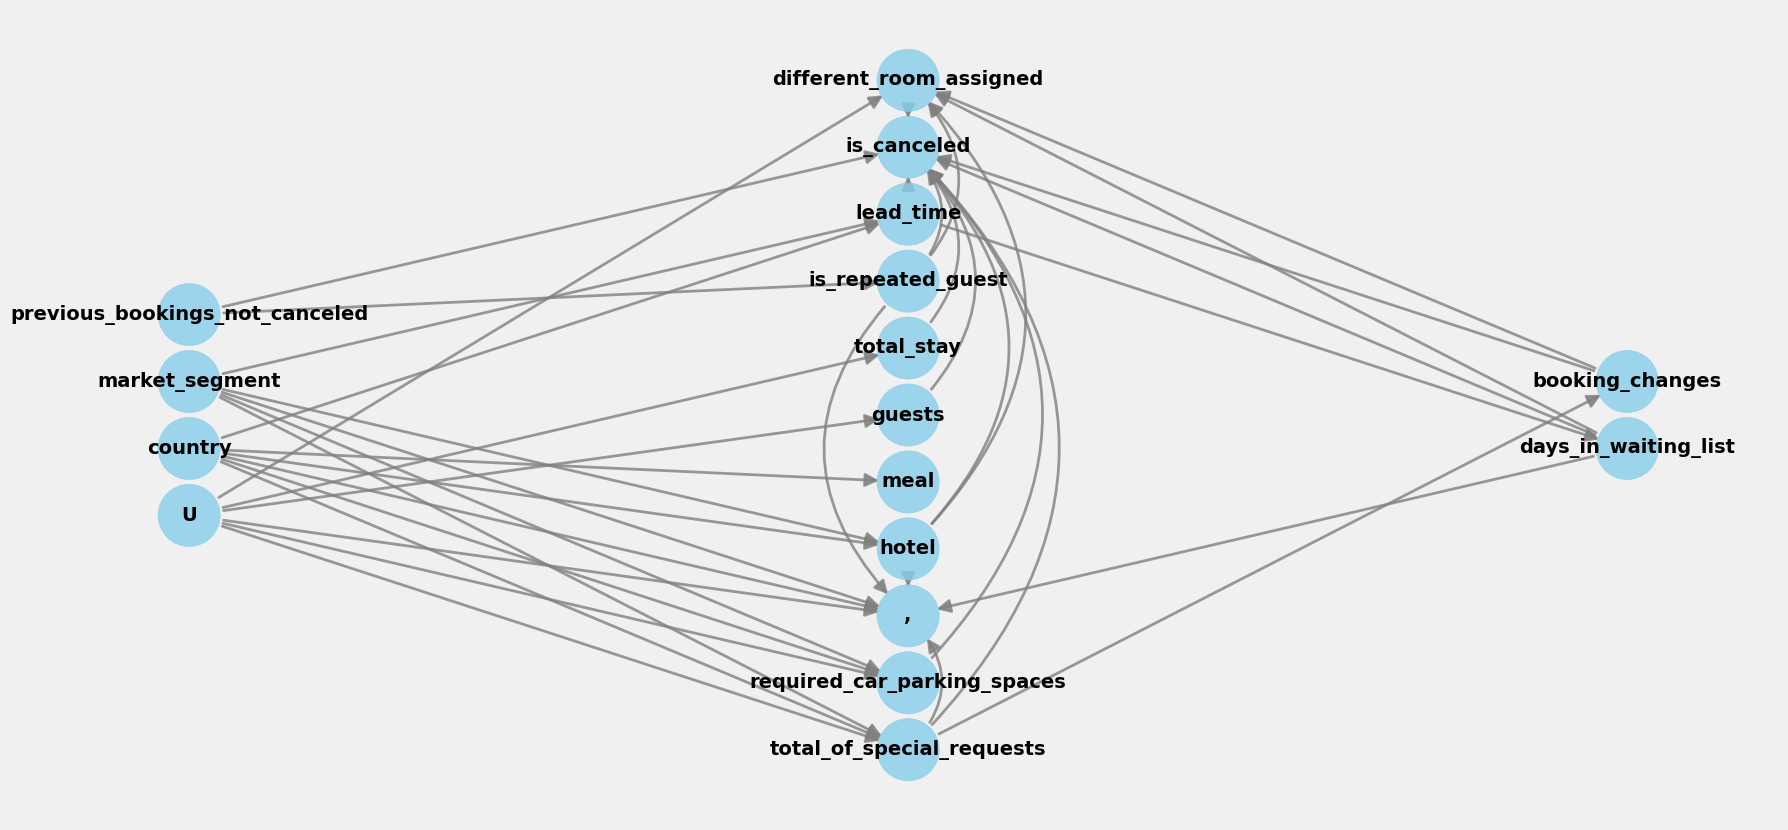

In [ ]:
model= dowhy.CausalModel(
        data = dataset,
        graph=causal_graph.replace("\n", " "),
        treatment="different_room_assigned",
        outcome='is_canceled')
model.view_model(size= (CFG.img_dim1, CFG.img_dim2))

Step 2 involves identification of the causal effect and returning target estimands: Treatment causes Outcome if changing Treatment leads to a change in Outcome keeping everything else constant.

In [ ]:
#Identify the causal effect
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
            d                                                                 
──────────────────────────(E[is_canceled|total_of_special_requests,lead_time,b
d[different_room_assigned]                                                    

                                                                              
ooking_changes,days_in_waiting_list,required_car_parking_spaces,total_stay,gue
                                                                              

                             
sts,is_repeated_guest,hotel])
                             
Estimand assumption 1, Unconfoundedness: If U→{different_room_assigned} and U→is_canceled then P(is_canceled|different_room_assigned,total_of_special_requests,lead_time,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_stay,guests,is_repeated_guest,hotel,U) = P(is_canceled|different_room_assigned,total_

In step 3 we estimate the target estimand using a statistical method:

In [ ]:
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.propensity_score_weighting",target_units="ate")


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [ ]:
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
            d                                                                 
──────────────────────────(E[is_canceled|total_of_special_requests,lead_time,b
d[different_room_assigned]                                                    

                                                                              
ooking_changes,days_in_waiting_list,required_car_parking_spaces,total_stay,gue
                                                                              

                             
sts,is_repeated_guest,hotel])
                             
Estimand assumption 1, Unconfoundedness: If U→{different_room_assigned} and U→is_canceled then P(is_canceled|different_room_assigned,total_of_special_requests,lead_time,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_stay,guests,is_repeated_guest,hotel,U

Step 4 involves scrutinizing the obtained estimate by subjecting it to various robustness checks, aiming to challenge its validity and stability.

In [ ]:
# Random Common Cause:- Adds randomly drawn covariates to data and re-runs the analysis to see if the causal estimate changes or not.
# If our assumption was originally correct then the causal estimate shouldn't change by much.

refute1_results = model.refute_estimate(identified_estimand, estimate,
                                      method_name="random_common_cause")
print(refute1_results)

Refute: Add a random common cause
Estimated effect:-0.26208282041490744
New effect:-0.26208282041490744
p value:1.0



In [ ]:
# Placebo Treatment Refuter:- Randomly assigns any covariate as a treatment and re-runs the analysis. If our assumptions were correct then this newly found out estimate should go to 0.

refute2_results = model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter")
print(refute2_results)



Refute: Use a Placebo Treatment
Estimated effect:-0.26208282041490744
New effect:0.055730578659796484
p value:0.0



In [ ]:
# Data Subset Refuter:- Creates subsets of the data(similar to cross-validation) and checks whether the causal estimates vary across subsets.
# If our assumptions were correct there shouldn't be much variation.

refute3_results = model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter")
print(refute3_results)


Refute: Use a subset of data
Estimated effect:-0.26208282041490744
New effect:-0.26209624289679495
p value:0.88



The "Data Subset Refuter" method functions akin to cross-validation by generating various subsets of the data and examining whether the causal estimates differ across these subsets. The premise is that if our causal assumptions are accurate, there should be minimal variation in the estimates across different subsets.

Upon execution, the `refute_estimate` function analyzes the identified estimand and the estimated causal effect using this specific method. The `refute3_results` variable stores the results obtained from this process. These results can offer insights into the stability and consistency of the causal estimates when the data is partitioned into subsets, helping to evaluate the robustness of the causal inference.

#Conclusion
Granger causality and causal inference offer valuable insights into relationships between variables, shedding light on potential cause-and-effect dynamics. Here are some conclusions you might draw based on their application:

1. **Understanding Interconnectedness:** Granger causality analysis provides a framework to assess temporal relationships between variables. By determining if one time series provides predictive information about another, it helps identify potential interdependencies, showcasing how variables might influence each other over time.

2. **Identifying Potential Causation:** Causal inference, on the other hand, aims to discern true causal relationships from observational data. By employing various statistical methods and considering temporal order, it helps unveil potential cause-and-effect connections between variables, going beyond mere correlation.

3. **Decision-Making Insights:** Together, these methodologies can offer critical insights for decision-making. Granger causality provides predictive leads, while causal inference helps establish the more robust and potentially causal relationships among variables. These insights can aid in making informed decisions, especially in fields like economics, social sciences, healthcare, and beyond.

4. **Robustness Testing:** Applying multiple robustness checks, as seen in causal inference, enhances confidence in identified relationships. It's crucial to subject these relationships to various tests to ensure stability and validity across different scenarios or subsets of data, validating the reliability of the inferred causal connections.

5. **Cautious Interpretation:** While both methodologies provide valuable insights, it's important to interpret their results carefully. Granger causality might highlight temporal correlations, but it doesn't imply causation. Causal inference strives to establish causation, yet it's crucial to consider potential biases and unobserved confounders.

In conclusion, integrating insights from Granger causality and causal inference can provide a more comprehensive understanding of relationships within datasets, aiding in decision-making and offering deeper insights into potential cause-and-effect dynamics.

#References
Medium Article https://towardsdatascience.com/inferring-causality-in-time-series-data-b8b75fe52c46

Science Direct https://www.sciencedirect.com/topics/social-sciences/causal-inference#:~:text=Causal%20inference%20refers%20to%20an,causal%20conclusions%20based%20on%20data.

Harvard article https://www.hsph.harvard.edu/miguel-hernan/causal-inference-book/

Aptech https://www.aptech.com/blog/introduction-to-granger-causality/

Medium article https://towardsdatascience.com/a-quick-introduction-on-granger-causality-testing-for-time-series-analysis-7113dc9420d2


MIT License

Copyright (c) 2023 Viral Jangale

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

